<a href="https://colab.research.google.com/github/davidsjohnson/wise24_xai_ac/blob/main/notebooks/tutorial_audio_xai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 2 - Explaining Speech Emotion Recognition

In this notebook you will attempt to explanations of a speech emotion recognition (SER) task using tabular data and a XGBoost classifier. As well as a CNN trained on spectrograms.

To use this notebook, please make sure to go step by step through each of the cells review the code and comments along the way.

Make sure to read the Notebook 2 section of the **README** beforing starting this notebook for all installation instructions.

## Notebook Setup

Make sure to uncomment code based on if you are running locally or via Google Colab

In [13]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
if IN_COLAB:
    !git clone https://github.com/davidsjohnson/xai_ac_wise25.git
# fix xgboost incompatiblity issue
    %pip uninstall -y -q scikit-learn
    %pip install -q scikit-learn==1.5.2

In [14]:
import sys
import os
if IN_COLAB:
  sys.path.append(os.path.realpath('xai_ac_wise25'))
else:
  sys.path.append(os.path.realpath('../'))

In [15]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

import librosa
import librosa.display

import matplotlib.pyplot as plt

from IPython.display import Audio
import IPython

import utils
import models
import evaluate
base_dir = Path('../data/') if not IN_COLAB else Path('xai_ac_wise25/data/')

## Setup Datasets

### Download Data and Extract Features

First we need to load our datast.  For this task, we will be using the audio portion of the [Ravdess dataset](https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio).  

For the tabular dataset, we provide you with preextracted features in the form of a pandas dataframe.  Tabular features were extracted with the [openSmile](https://audeering.github.io/opensmile-python/) package using the [Extended Geneva Minimalistic Acoustic Parameter
Set (EGeMAPS)](https://mediatum.ub.tum.de/doc/1523509/file.pdf). Please have a look at the paper for a detailed explanation of the different features.

We will also extract Spectrograms from the audio clips using librosa.

We are also providing 300 audio clips of the test dataset containing actors \[15,  8, 20, 11,  5\]

In [ ]:
# ravdess_link = 'https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1'
# data_dir = utils.download_file(url=ravdess_link,
#                                file_name="ravdess.zip",
#                                cache_dir= './data/ravdess',
#                                extract=True,
#                                force_download=False,
#                                archive_folder='')
# data_dir

File already exists at: data/ravdess/ravdess.zip


PosixPath('data/ravdess')

### Load the RAVDESS extracted Features

In [17]:
LABEL_DICT = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
LABEL_MAP_DICT = {v: k for k, v in LABEL_DICT.items()}
LABELS = list(LABEL_DICT.values())

# load dataframes from CSV
df_train = pd.read_csv(base_dir / 'ravdess_features/radvess_opensmile_train.csv')
df_test = pd.read_csv(base_dir / 'ravdess_features/radvess_opensmile_test.csv')

# update audio_paths to match new locations
audio_path = base_dir / 'ravdess_audioclips'
def update_paths(row):
    return str(audio_path / Path(row.path).name)
df_train.path = df_train.apply(update_paths, axis='columns')
df_test.path = df_test.apply(update_paths, axis='columns')

# get feature columns
feature_names = list(df_train.columns[6:])
print(feature_names)

['F0semitoneFrom27.5Hz_sma3nz_amean', 'F0semitoneFrom27.5Hz_sma3nz_stddevNorm', 'F0semitoneFrom27.5Hz_sma3nz_percentile20.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile50.0', 'F0semitoneFrom27.5Hz_sma3nz_percentile80.0', 'F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2', 'F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope', 'F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope', 'F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope', 'loudness_sma3_amean', 'loudness_sma3_stddevNorm', 'loudness_sma3_percentile20.0', 'loudness_sma3_percentile50.0', 'loudness_sma3_percentile80.0', 'loudness_sma3_pctlrange0-2', 'loudness_sma3_meanRisingSlope', 'loudness_sma3_stddevRisingSlope', 'loudness_sma3_meanFallingSlope', 'loudness_sma3_stddevFallingSlope', 'spectralFlux_sma3_amean', 'spectralFlux_sma3_stddevNorm', 'mfcc1_sma3_amean', 'mfcc1_sma3_stddevNorm', 'mfcc2_sma3_amean', 'mfcc2_sma3_stddevNorm', 'mfcc3_sma3_amean', 'mfcc3_sma3_stddevNorm', 'mfcc4_sma3_amean', 'mfcc4_sma3_std

### Review the Extracted Features

In [18]:
# review a random sample of the training data
df_train.sample(5)

Unnamed: 0  actor  emotion  intensity  \
188         188     24        1          2   
466         466     18        2          2   
363         363      2        7          1   
194         194     24        7          2   
894         894      4        4          2   

                                                  path emotion_label  \
188  ../data/ravdess_audioclips/03-01-02-02-02-02-2...          calm   
466  ../data/ravdess_audioclips/03-01-03-02-02-02-1...         happy   
363  ../data/ravdess_audioclips/03-01-08-01-02-02-0...      surprise   
194  ../data/ravdess_audioclips/03-01-08-02-01-01-2...      surprise   
894  ../data/ravdess_audioclips/03-01-05-02-01-01-0...         angry   

     F0semitoneFrom27.5Hz_sma3nz_amean  \
188                          36.041786   
466                          48.264248   
363                          39.480831   
194                          43.539474   
894                          45.492310   

     F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
188                                0.056676   
466                                0.055875   
363                                0.189527   
194                                0.138447   
894                                0.106875   

     F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
188                                   34.429817   
466                                   46.873608   
363                                   35.258656   
194                                   38.441360   
894                                   42.292160   

     F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
188                                   35.293888  ...   
466                                   48.190769  ...   
363                                   38.416981  ...   
194                                   41.650421  ...   
894                                   45.836426  ...   

     slopeUV0-500_sma3nz_amean  slopeUV500-1500_sma3nz_amean  \
188                   0.114088                      0.006104   
466                   0.071225                      0.013032   
363                   0.080886                      0.009010   
194                   0.086890                      0.008436   
894                   0.098046                      0.011992   

     spectralFluxUV_sma3nz_amean  loudnessPeaksPerSec  VoicedSegmentsPerSec  \
188                     0.009656             2.200489              1.732673   
466                     0.036677             2.356021              0.795756   
363                     0.009381             2.556818              0.864553   
194                     0.032158             2.040816              1.550388   
894                     0.079532             2.393617              1.078167   

     MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
188                    0.205714                      0.110306   
466                    0.513333                      0.041096   
363                    0.436667                      0.345864   
194                    0.248333                      0.151263   
894                    0.342500                      0.230583   

     MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
188                   0.348571                     0.421102   
466                   0.716667                     0.454337   
363                   0.522500                     0.457896   
194                   0.321429                     0.430429   
894                   0.450000                     0.471975   

     equivalentSoundLevel_dBp  
188                -48.779408  
466                -22.794733  
363                -38.597374  
194                -33.897774  
894                -23.143410  

[5 rows x 94 columns]

In [20]:
# review the extracted features

audio_sample = df_test.sample(1)
audio_sample

Unnamed: 0  actor  emotion  intensity  \
205        1345      8        3          1   

                                                  path emotion_label  \
205  ../data/ravdess_audioclips/03-01-04-01-02-01-0...           sad   

     F0semitoneFrom27.5Hz_sma3nz_amean  \
205                          35.626324   

     F0semitoneFrom27.5Hz_sma3nz_stddevNorm  \
205                                0.020898   

     F0semitoneFrom27.5Hz_sma3nz_percentile20.0  \
205                                   34.908585   

     F0semitoneFrom27.5Hz_sma3nz_percentile50.0  ...  \
205                                   35.578808  ...   

     slopeUV0-500_sma3nz_amean  slopeUV500-1500_sma3nz_amean  \
205                  -0.005152                       0.00814   

     spectralFluxUV_sma3nz_amean  loudnessPeaksPerSec  VoicedSegmentsPerSec  \
205                     0.009106             2.808989              1.424501   

     MeanVoicedSegmentLengthSec  StddevVoicedSegmentLengthSec  \
205                        0.17                      0.119164   

     MeanUnvoicedSegmentLength  StddevUnvoicedSegmentLength  \
205                      0.425                     0.487331   

     equivalentSoundLevel_dBp  
205                -52.310444  

[1 rows x 94 columns]

In [21]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

In [10]:
# basepath = Path('./output')

# output_path = basepath / 'ravdess'
# feature_path = output_path / 'features'
# audio_path = output_path / 'audio_clips'
# model_path = output_path /'model'

# os.makedirs(feature_path, exist_ok=True)
# os.makedirs(audio_path, exist_ok=True)

### Extract Spectrograms

In [22]:
def get_log_melspec(data, sample_rate, silence_thresh=25):
  """
  Function for extracting features from an audio sample.  The audio is preprocess to remove silence and then
  padded on both sides to ensure each clip is 5 seconds.
  Then the log mel spectrogram is extracted.
  """
  trimmed, _ = librosa.effects.trim(data, top_db=silence_thresh)
  padded = np.pad(trimmed, (int(sample_rate*2.5-len(trimmed)//2), int(sample_rate*2.5-len(trimmed)//2)), 'constant')
  mel = librosa.feature.melspectrogram(y=padded, sr=sample_rate, n_fft=2048, hop_length=512, n_mels=128)
  return librosa.power_to_db(mel, ref=np.max)

In [23]:
# setup dictionary to store data
data = dict(
    actor = [],
    emotion = [],
    intensity = [],
    gender = [],
    path = []
)

# final all wave files
wav_files = data_dir.rglob('*.wav')

# process each file
for wav in wav_files:

    # extract details from filename (see zenodo page for details)
    _, _, emo, emo_int, _, _, actor = wav.stem.split('-')

    data['actor'].append(int(actor))
    data['emotion'].append(int(emo)-1)
    data['intensity'].append(int(emo_int))
    data['gender'].append('male' if int(actor) % 2 == 0 else 'female')
    data['path'].append(str(wav))

df_rav = pd.DataFrame.from_dict(data)
df_rav['emotion_label'] = df_rav.emotion.replace(LABEL_DICT, inplace=False)

# extract features and save to dataframe
def load_melspec(row):
  a, sr = librosa.load(row['path'], sr=16000)
  return get_log_melspec(a, sr, silence_thresh=55)

df_rav['spectro'] = df_rav.apply(load_melspec, axis=1)

In [24]:
# validate extracted features
for idx, row in df_rav.iterrows():
  assert row.spectro.shape == (128, 157), f'shape: {row.spectro.shape}'

### Review the Spectrogram Data

In [28]:
# review one row
audio_sample = df_rav.sample(1)
audio_sample

actor  emotion  intensity  gender  \
1089     19        1          2  female   

                                                path emotion_label  \
1089  data/ravdess/Actor_19/03-01-02-02-01-02-19.wav          calm   

                                                spectro  
1089  [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...

In [29]:
# Display Audio to list to
Audio(audio_sample['path'].values[0])

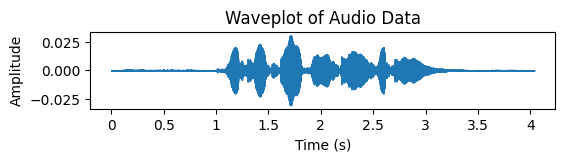

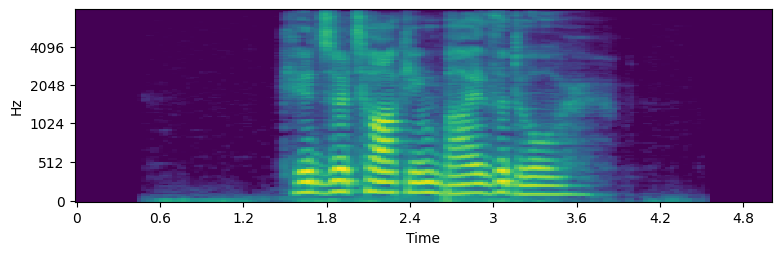

In [30]:
# load audio and downsample to 16000
y, sr = librosa.load(audio_sample['path'].values[0], sr=16000)

# Create wave plot
plt.figure(figsize=(6, 1))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveplot of Audio Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(9,2.5))
librosa.display.specshow(audio_sample['spectro'].values[0],
                         sr=sr, hop_length=512, n_fft=2048,
                         x_axis='time', y_axis='mel',
                         cmap = 'viridis'
                         )
plt.show()

## Explain Tabular Data for FER

### Train an XGBoost Model

Now we train an XGBoost model to perform explanations.  The model should get $100\%$ on the training data.

In [31]:
from xgboost import XGBClassifier

In [32]:
random_state = 24

xgb = XGBClassifier(n_estimators=20, 
                    max_depth=15,
                    learning_rate=0.1, 
                    objective='binary:logistic',
                    random_state=random_state)

xgb.fit(df_train[feature_names], df_train['emotion'])
score = xgb.score(df_train[feature_names], df_train['emotion'])
print(f'Train Accuracy: {score*100:.2f}%')

Train Accuracy: 100.00%


### Evaluate the model

Now let's evaluate the performance of the RDF Classifier on the `X_aus` dataset. The accuracy should be around $45.67\%$, indicating significant overfitting. However, it is much better than random guessing at $12.5\%$

We should also generate the predictions of the model for the dataset, and store them in the dataframe.

In [33]:
score = xgb.score(df_test[feature_names], df_test['emotion'])
print(f'Test Accuracy: {score*100:.2f}%')

# generate predictions for later user
df_test['emotion_pred'] = xgb.predict(df_test[feature_names])
(df_test['emotion_pred'] == df_test['emotion']).mean()

Test Accuracy: 45.67%


0.45666666666666667

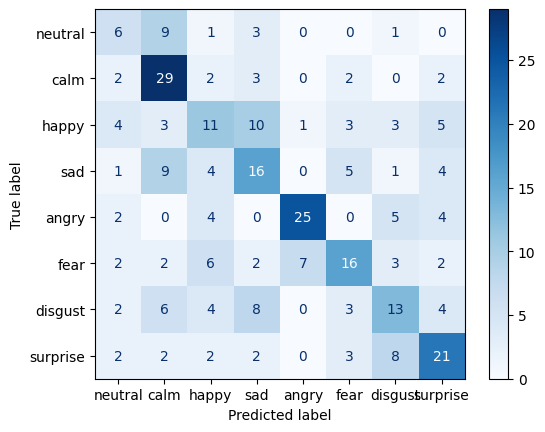

In [34]:
cm = confusion_matrix(df_test['emotion'], df_test['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

#### Review some predictions

In [35]:
audio_samples = df_test.sample(5)
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 213 - Emotion: sad | Prediction: sad
../data/ravdess_audioclips/03-01-04-02-01-01-08.wav


Index: 63 - Emotion: calm | Prediction: calm
../data/ravdess_audioclips/03-01-02-02-01-02-20.wav


Index: 247 - Emotion: neutral | Prediction: sad
../data/ravdess_audioclips/03-01-01-01-02-01-15.wav


Index: 24 - Emotion: happy | Prediction: surprise
../data/ravdess_audioclips/03-01-03-01-01-02-05.wav


Index: 106 - Emotion: neutral | Prediction: calm
../data/ravdess_audioclips/03-01-01-01-01-01-20.wav


## Explainations of Spectrograms

### Setup Data Loaders

In [22]:
# # split dataset by actors
# all_actors = df_rav['actor'].unique()
# actors_gender = df_rav.groupby('actor')['gender'].unique().reset_index()

# train_actors, tmp = train_test_split(actors_gender, train_size=10, stratify=actors_gender['gender'], random_state=36851234)
# val_actors, test_actors = train_test_split(tmp, train_size=8, stratify=tmp['gender'], random_state=36851234)

# train_actors = train_actors['actor'].tolist()
# val_actors = val_actors['actor'].tolist()
# test_actors = test_actors['actor'].tolist()

# df_train = df_rav[df_rav['actor'].isin(train_actors)]
# df_val = df_rav[df_rav['actor'].isin(val_actors)]
# df_test = df_rav[df_rav['actor'].isin(test_actors)]

In [36]:
# Random data set split
df_train_cnn = df_rav.sample(frac=.8, random_state=0)
df_val_cnn = df_rav.drop(df_train_cnn.index).sample(frac=.5, random_state=0)
df_test_cnn = df_rav.drop(df_train_cnn.index).drop(df_val_cnn.index)

In [37]:
def get_dataset(df, feats_col, labels_col):
  labels = df[labels_col].values

  # convert from object array in dataframe to floats
  # and convert to numpy array
  feats = df[feats_col]
  feats = [f.astype(float) for f in feats]
  feats = np.array(feats)
  feats = feats[:, None, :, :]

  idxs = df.index.values

  # Setup features and labels as tensors
  X = torch.tensor(feats, dtype=torch.float32)
  y = torch.tensor(labels, dtype=torch.long)
  idxs = torch.tensor(idxs, dtype=torch.long)

  # Create TensorDataset
  dataset = TensorDataset(X, y, idxs)

  return dataset

In [38]:
# setup dataloaders based on previous dataset split
ds_train = get_dataset(df_train_cnn, 'spectro', 'emotion')
ds_val = get_dataset(df_val_cnn, 'spectro', 'emotion')
ds_test = get_dataset(df_test_cnn, 'spectro', 'emotion')

dl_train = DataLoader(ds_train, batch_size=64, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=1, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)

### Load Pretrained Model

In [39]:
# get checkpoint
ckpt_link = 'https://uni-bielefeld.sciebo.de/s/eiOiBrhuOENmo0p/download'
ckpt_path = utils.download_file(ckpt_link,
                                'ravdess_model.pth',
                                cache_dir='./data/ravdess/model',
                                extract=False,
                                force_download=False
                                )
ckpt_path

File downloaded to: data/ravdess/model/ravdess_model.pth


PosixPath('data/ravdess/model/ravdess_model.pth')

In [40]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [41]:
# To load the best model:
model = models.ResNet(len(LABELS))
model.load_state_dict(torch.load(ckpt_path, map_location='cpu'))
model.to(device);

### Evaluate Model

Next we will evaluate the loaded model to ensure it is working as expected.  You should get around $92.36\%$ accurac on the test set. The accuracy is high, because the model was not split between actors as we did in the previous example

In [42]:
evaluate.evaluate_model(model, dl_train, criterion, device)
evaluate.evaluate_model(model, dl_val, criterion, device)
_, _, test_preds, test_probs = evaluate.evaluate_model(model, dl_test, criterion, device)

Evaluation Loss: 0.2322, Evaluation Accuracy: 0.9375
Evaluation Loss: 0.1828, Evaluation Accuracy: 0.9444
Evaluation Loss: 0.1427, Evaluation Accuracy: 0.9375


In [43]:
# load probabilities and predictions into dataframe for test dataset
df_test_cnn['emotion_pred'] = test_preds
(df_test_cnn['emotion'] == df_test_cnn['emotion_pred']).mean()

0.9375

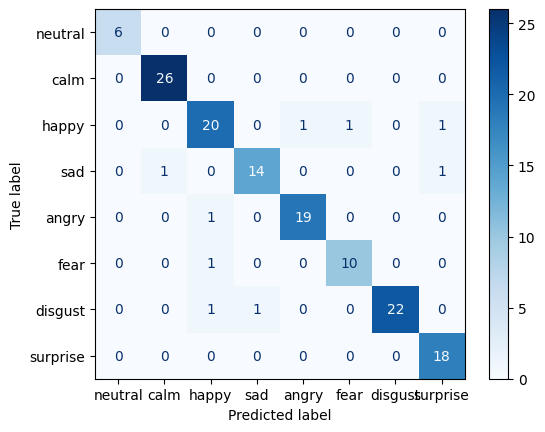

In [44]:
cm = confusion_matrix(df_test_cnn['emotion'], df_test_cnn['emotion_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap='Blues')
plt.grid(False)

#### Review some predictions

In [46]:
audio_samples = df_test_cnn.sample(5)
for idx, sample in audio_samples.iterrows():
    print(f'Index: {idx} - Emotion: {sample.emotion_label} | Prediction: {LABELS[sample.emotion_pred]}')
    print(sample.path)
    IPython.display.display(IPython.display.Audio(sample.path))

Index: 508 - Emotion: angry | Prediction: angry
data/ravdess/Actor_09/03-01-05-01-01-01-09.wav


Index: 1252 - Emotion: surprise | Prediction: surprise
data/ravdess/Actor_21/03-01-08-01-01-01-21.wav


Index: 1289 - Emotion: angry | Prediction: angry
data/ravdess/Actor_22/03-01-05-01-01-02-22.wav


Index: 952 - Emotion: surprise | Prediction: surprise
data/ravdess/Actor_16/03-01-08-01-01-01-16.wav


Index: 628 - Emotion: angry | Prediction: angry
data/ravdess/Actor_11/03-01-05-01-01-01-11.wav
